## Feature selection

Correlation Feature Selection evaluates subsets of features on the basis of the following hypothesis: "Good feature subsets contain features highly correlated with the target, yet uncorrelated to each other".

I will demonstrate how to select features based on correlation using 2 procedures:

The first one is a brute force function that finds correlated features without any further insight.

The second procedure finds groups of correlated features, which we can then explore to decide which one we keep and which ones we discard.

Often, more than 2 features are correlated with each other. We can find groups of 3, 4 or more features that are correlated. By identifying these groups, with procedure 2, we can then select from each group, which feature we want to keep, and which ones we want to remove.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, DropCorrelatedFeatures

from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
# to obtain the mutual information values
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge

# to determine the p-values with anova
from sklearn.feature_selection import f_classif

# to select features
from sklearn.feature_selection import SelectKBest

# to select the features
from sklearn.feature_selection import SelectKBest, SelectPercentile
import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

In [14]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH_TWO_PL")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Label,Gender,Age,DIAGNOSIS,MMSE,Hip ASM,Hip Contrast,Hip Correlation,Hip Variance,Hip Sum Average,...,ERC CONTRAST,ERC CORRELATION,ERC VARIANCE,ERC SUM AVERAGE,ERC SUM VARIANCE,ERC ENTROPY,ERC CLUSTER SHADE,ERCs_thicknessbaseline,ERCsVolumebaseline,TOTAL_HIPPOCAMPUS_VOLUME
0,30879,0,64.585900,0,27.0,0.377501,128.715226,0.422342,115.630163,15.181458,...,286.270009,0.289728,206.373786,44.577974,539.225137,3.320292,22924.739100,3.3445,2251,7338.2
1,31129,0,68.076660,2,20.0,0.657212,51.830551,0.557254,84.225204,8.530596,...,282.873623,0.310507,206.276556,39.697933,542.232602,2.864138,18182.687670,2.9605,2924,5438.6
2,30605,1,76.221760,1,28.0,0.520032,86.558742,0.594543,123.662642,13.400504,...,244.274039,0.370189,201.216707,46.081559,560.592790,3.415186,28045.350990,3.3145,4042,8434.4
3,30039,0,73.221085,0,30.0,0.396133,60.731686,0.596733,122.546512,15.571183,...,226.713342,0.517430,232.983710,30.461877,705.221498,2.937422,1196.160472,3.1505,3485,7476.2
4,30079,0,45.872690,0,30.0,0.404800,108.808540,0.520363,98.065558,13.483247,...,202.074647,0.354851,169.528802,50.680275,476.040561,3.017047,47743.254120,3.5420,3964,8021.8


In [15]:
# Split by subject
subjects = dataset['Label'].unique()
first_diag_per_subject = dataset.groupby('Label')['DIAGNOSIS'].first()

train_subs, test_subs = train_test_split(
    subjects,
    test_size=0.3,
    random_state=42,
    stratify=first_diag_per_subject
)

# Assign rows
train_df = dataset[dataset['Label'].isin(train_subs)].copy()
test_df  = dataset[dataset['Label'].isin(test_subs)].copy()

# Separate X and y
y_train = train_df['DIAGNOSIS']
y_test  = test_df['DIAGNOSIS']
X_train = train_df.drop(columns=['DIAGNOSIS'])
X_test  = test_df.drop(columns=['DIAGNOSIS'])

# -----------------------------
# Check for subject-level overlap
# -----------------------------
overlap_subjects = set(train_df['Label']).intersection(set(test_df['Label']))
if len(overlap_subjects) == 0:
    print("No subjects appear in both train and test sets.")
else:
    print(f"Overlapping subjects found: {overlap_subjects}")

print(f"Number of subjects in train: {len(train_df['Label'].unique())}")
print(f"Number of subjects in test: {len(test_df['Label'].unique())}")


No subjects appear in both train and test sets.
Number of subjects in train: 508
Number of subjects in test: 219


In [16]:
imputer_nonLin = IterativeImputer(
    estimator=ExtraTreesRegressor(),
    random_state=42,
)

imputer_nonLin.fit(X_train)
X_train_missForest = imputer_nonLin.transform(X_train)
X_test_missForest = imputer_nonLin.transform(X_test)

In [17]:
X_train_missForest_t = pd.DataFrame(X_train_missForest, columns=X_train.columns)
X_test_missForest_t = pd.DataFrame(X_test_missForest, columns=X_test.columns)

In [18]:
from sklearn.preprocessing import StandardScaler

cols = [
    'Hip ASM', 'Hip Contrast', 'Hip Correlation', 'Hip Variance ', 'Hip Sum Average',
       'Hip Sum Variance', 'Hip Entropy', 'Hip Clusterhade', 'ERC ASM',
       'ERC CONTRAST', 'ERC CORRELATION', 'ERC VARIANCE ', 'ERC SUM AVERAGE',
       'ERC SUM VARIANCE', 'ERC ENTROPY', 'ERC CLUSTER SHADE',
       'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'TOTAL_HIPPOCAMPUS_VOLUME'
]

scaler = StandardScaler()

# X_train_bayes_t
X_train_missForest_t[cols] = scaler.fit_transform(X_train_missForest_t[cols])

# X_test_bayes_t
X_test_missForest_t[cols] = scaler.transform(X_test_missForest_t[cols])

In [19]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
    ('correlated', DropCorrelatedFeatures(threshold=0.9, method='spearman', missing_values='ignore',))
])

pipe.fit(X_train_missForest_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures()),
                ('correlated',
                 DropCorrelatedFeatures(method='spearman', threshold=0.9))])

In [20]:
constant_step = pipe.named_steps['constant']
quasi_constant_step = pipe.named_steps['quasi-constant']
duplicated_step = pipe.named_steps['duplicated']
correlated_step = pipe.named_steps['correlated']


print("Constant features removed:", constant_step.features_to_drop_)
print("Quasi-constant features removed:", quasi_constant_step.features_to_drop_)
print("Duplicate features removed:", duplicated_step.features_to_drop_)
print("Correlated features removed:", correlated_step.features_to_drop_)

Constant features removed: []
Quasi-constant features removed: []
Duplicate features removed: set()
Correlated features removed: ['ERC SUM AVERAGE']


In [21]:
# remove features
X_train_t = pipe.transform(X_train_missForest_t)
X_test_t = pipe.transform(X_test_missForest_t)

X_train_t.shape, X_test_t.shape

((508, 22), (219, 22))

In [22]:
correlated_step.correlated_feature_sets_

[{'ERC ASM', 'ERC SUM AVERAGE'}]

In [23]:
correlated_step.correlated_feature_dict_

{'ERC ASM': {'ERC SUM AVERAGE'}}

In [24]:
X_train_t.columns

Index(['Label', 'Gender', 'Age', 'MMSE', 'Hip ASM', 'Hip Contrast',
       'Hip Correlation', 'Hip Variance ', 'Hip Sum Average',
       'Hip Sum Variance', 'Hip Entropy', 'Hip Clusterhade', 'ERC ASM',
       'ERC CONTRAST', 'ERC CORRELATION', 'ERC VARIANCE ', 'ERC SUM VARIANCE',
       'ERC ENTROPY', 'ERC CLUSTER SHADE', 'ERCs_thicknessbaseline',
       'ERCsVolumebaseline', 'TOTAL_HIPPOCAMPUS_VOLUME'],
      dtype='object')

## Classification Test

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def run_model(classifier_name, X_train, y_train):
        
        columns = len(X_train.columns)
        
        # Initialize the model based on classifier_name
        if classifier_name == "Random Forest":
                model = RandomForestClassifier(n_estimators=100, 
                                        max_depth=5, 
                                        random_state=42, 
                                        class_weight="balanced")
                
        elif classifier_name == "XGBoost":
        # XGBClassifier sometimes issues warnings about label encoding. 
        # We disable the use_label_encoder and set an evaluation metric.
                model = XGBClassifier(n_estimators=100, 
                                max_depth=5, 
                                random_state=42,
                                eval_metric="logloss")
        
        elif classifier_name == "NGBoost":
                model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                                      n_estimators=100,
                                      verbose=False)
                
        elif classifier_name == "Logistic Regression":
                model = LogisticRegression(
                class_weight="balanced",
                solver="lbfgs",
                max_iter=500,
                random_state=42
                )

        else:
                raise ValueError("Unknown classifier")
                
        kf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": "Correlation",
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": columns,
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [26]:
trained_rf_n, metrics_rf_n = run_model("Random Forest", X_train_missForest_t, y_train)
trained_rf_t, metrics_rf_t = run_model("Random Forest", X_train_t, y_train)

trained_xgb_n, metrics_xgb_n = run_model("XGBoost", X_train_missForest_t, y_train)
trained_xgb_t, metrics_xgb_t = run_model("XGBoost", X_train_t, y_train)

trained_ngb_n, metrics_ngb_n = run_model("NGBoost", X_train_missForest_t, y_train)
trained_ngb_t, metrics_ngb_t = run_model("NGBoost", X_train_t, y_train)

trained_lg_n, metrics_lg_n = run_model("Logistic Regression", X_train_missForest_t, y_train)
trained_lg_t, metrics_lg_t = run_model("Logistic Regression", X_train_t, y_train)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

In [27]:
validation_df = pd.concat([metrics_rf_n, metrics_rf_t, metrics_xgb_n, metrics_xgb_t, metrics_ngb_n, metrics_ngb_t, metrics_lg_n])
validation_df_report = validation_df.set_index(["Feature Selection", "Classifier", "Metric", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Feature Selection Classifier          Metric            Fit Time Total Features               
Correlation       Random Forest       balanced_accuracy 0.343    23                   0.928   
                                                        0.338    22                   0.933   
                  XGBoost             balanced_accuracy 0.540    23                   1.000   
                                                        0.619    22                   1.000   
                  NGBoost             balanced_accuracy 1.791    23                   0.618   
                                                        1.760    22                   0.623   
                  Logistic Regression balanced_accuracy 0.151    23                   0.662   

                                                                                 Std Train  \
Feature Selection Classifier          Metric            Fit Time Total Features              
Correlation       Random Forest       balanced_accuracy 0.343    23                  0.011   
                                                        0.338    22                  0.013   
                  XGBoost             balanced_accuracy 0.540    23                  0.000   
                                                        0.619    22                  0.000   
                  NGBoost             balanced_accuracy 1.791    23                  0.023   
                                                        1.760    22                  0.018   
                  Logistic Regression balanced_accuracy 0.151    23                  0.019   

                                                                                 Mean Test  \
Feature Selection Classifier          Metric            Fit Time Total Features              
Correlation       Random Forest       balanced_accuracy 0.343    23                  0.570   
                                                        0.338    22                  0.563   
                  XGBoost             balanced_accuracy 0.540    23                  0.556   
                                                        0.619    22                  0.564   
                  NGBoost             balanced_accuracy 1.791    23                  0.526   
                                                        1.760    22                  0.527   
                  Logistic Regression balanced_accuracy 0.151    23                  0.552   

                                                                                 Std Test  
Feature Selection Classifier          Metric            Fit Time Total Features            
Correlation       Random Forest       balanced_accuracy 0.343    23                 0.051  
                                                        0.338    22                 0.054  
                  XGBoost             balanced_accuracy 0.540    23                 0.069  
                                                        0.619    22                 0.069  
                  NGBoost             balanced_accuracy 1.791    23                 0.038  
                                                        1.760    22                 0.042  
                  Logistic Regression balanced_accuracy 0.151    23                 0.104

In [28]:
from sklearn.utils import resample

def bootstrap_ci(model, X, y, metric_fn, n_iterations, ci=0.95, use_proba=False):
    scores = []
    n = len(X)
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X, y, n_samples=n, stratify=y)
        try:
            y_pred = model.predict_proba(X_resampled) if use_proba else model.predict(X_resampled)
            score = metric_fn(y_resampled, y_pred)
            if not np.isnan(score):
                scores.append(score)
        except Exception:
            # Skip this bootstrap sample if error occurs (e.g. missing class for roc_auc)
            continue
    if len(scores) == 0:
        return (np.nan, np.nan)
    lower = np.percentile(scores, (1 - ci) / 2 * 100)
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    std_dev = np.std(scores)
    return round(lower, 3), round(upper, 3), round(std_dev, 3)

In [29]:
from sklearn.metrics import confusion_matrix

def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = total - (tp + fp + fn)
    specificity = tn / (tn + fp)
    return round(np.nanmean(specificity), 3)

In [30]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        columns = len(X_train.columns)

        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": accuracy_score(y_train, pred_train),
                "balanced_accuracy": balanced_accuracy_score(y_train, pred_train),
                "precision_macro": precision_score(y_train, pred_train, average="macro", zero_division=0),
                "recall_macro": recall_score(y_train, pred_train, average="macro", zero_division=0),
                "f1_macro": f1_score(y_train, pred_train, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_train, pred_train_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_train, pred_train),
        }

        metrics_test = {
                "accuracy": accuracy_score(y_test, pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, pred_test),
                "precision_macro": precision_score(y_test, pred_test, average="macro", zero_division=0),
                "recall_macro": recall_score(y_test, pred_test, average="macro", zero_division=0),
                "f1_macro": f1_score(y_test, pred_test, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_test, pred_test_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_test, pred_test),
        }
                
        elapsed_time = time.time() - start_time
        
        # Metric functions for bootstrap CI (exclude ROC AUC here)
        metric_fns = {
                "accuracy": accuracy_score,
                "balanced_accuracy": balanced_accuracy_score,
                "precision_macro": lambda yt, yp: precision_score(yt, yp, average="macro", zero_division=0),
                "recall_macro": lambda yt, yp: recall_score(yt, yp, average="macro", zero_division=0),
                "f1_macro": lambda yt, yp: f1_score(yt, yp, average="macro", zero_division=0),
                "roc_auc_macro": lambda yt, yp: roc_auc_score(yt, yp, average="macro", multi_class="ovr"),
                "specificity_macro": lambda yt, yp: compute_specificity(yt, yp),
        }

        # Bootstrap confidence intervals
        ci_test = {
                m: bootstrap_ci(
                model, X_test, y_test, fn,
                n_iterations=100,
                use_proba=(m == "roc_auc_macro")
                )
                for m, fn in metric_fns.items()
        }

        # Separate CI bounds and std with clear variable names
        ci_bounds = []
        std_values = []
                
        for lower, upper, std in ci_test.values():
                ci_bounds.append(f"[{round(lower, 3)}, {round(upper, 3)}]")
                std_values.append(round(std, 3)) 
                
        # Round metric values
        train_rounded = [round(score, 3) for score in metrics_train.values()]
        test_rounded = [round(score, 3) for score in metrics_test.values()] 
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Pearson",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": list(metrics_train.keys()),      
                "Train data": train_rounded,
                "Test data": test_rounded,
                "95% CI": ci_bounds,
                "Std Dev": std_values,
        })
        
        return pred_metrics_df

In [31]:
results = "all"
prediction_df_report = None

if results == "all":
    pred_rf_n = eval_model("Random Forest", trained_rf_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)

    pred_xgb_n = eval_model("XGBoost", trained_xgb_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)

    pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    pred_lg_n = eval_model("Logistic Regression", trained_lg_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_lg_t = eval_model("Logistic Regression", trained_lg_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_rf_n, pred_rf_t, pred_xgb_n, pred_xgb_t, pred_ngb_n, pred_ngb_t, pred_lg_n, pred_lg_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    pred_lg_t = eval_model("Logistic Regression", trained_lg_t, X_train_t, X_test_t, y_train, y_test)

    prediction_df = pd.concat([pred_rf_t, pred_xgb_t, pred_ngb_t, pred_lg_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier          Classification Time Total Features Metric                          
Pearson           Random Forest       0.115               23             accuracy                0.945   
                                                                         balanced_accuracy       0.923   
                                                                         precision_macro         0.927   
                                                                         recall_macro            0.923   
                                                                         f1_macro                0.925   
                                                                         roc_auc_macro           0.987   
                                                                         specificity_macro       0.955   
                                      0.086               22             accuracy                0.939   
                                                                         balanced_accuracy       0.923   
                                                                         precision_macro         0.906   
                                                                         recall_macro            0.923   
                                                                         f1_macro                0.914   
                                                                         roc_auc_macro           0.988   
                                                                         specificity_macro       0.954   
                  XGBoost             0.199               23             accuracy                1.000   
                                                                         balanced_accuracy       1.000   
                                                                         precision_macro         1.000   
                                                                         recall_macro            1.000   
                                                                         f1_macro                1.000   
                                                                         roc_auc_macro           1.000   
                                                                         specificity_macro       1.000   
                                      0.128               22             accuracy                1.000   
                                                                         balanced_accuracy       1.000   
                                                                         precision_macro         1.000   
                                                                         recall_macro            1.000   
                                                                         f1_macro                1.000   
                                                                         roc_auc_macro           1.000   
                                                                         specificity_macro       1.000   
                  NGBoost             1.171               23             accuracy                0.862   
                                                                         balanced_accuracy       0.590   
                                                                         precision_macro         0.924   
                                                                         recall_macro            0.590   
                                                                         f1_macro                0.630   
                                                                         roc_auc_macro           0.983   
                                                                         specificity_macro       0.849   
                                      0.523               22             accuracy                0.870   
                                                                

In [32]:
# Quick NGBoost check
lr_auc = prediction_df_report.xs(
    ("Pearson", "Logistic Regression", "roc_auc_macro"),
    level=("Feature Selection", "Classifier", "Metric")
)["Test data"]
print("NGBoost (Boruta) macro AUC:", lr_auc)

NGBoost (Boruta) macro AUC: Classification Time  Total Features
0.063                23                0.807
0.096                22                0.812
Name: Test data, dtype: float64


In [37]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_multi(models_dict, X_tests_dict, y_test, show_per_class=False):
    classes = sorted(np.unique(y_test))
    y_test_bin = label_binarize(y_test, classes=classes)
    
    plt.figure(figsize=(10, 7))
    
    for clf_name, imputer_models in models_dict.items():
        for imp_name, model in imputer_models.items():
            X_test = X_tests_dict[imp_name]
            y_proba = model.predict_proba(X_test)
            
            # Per-class ROC
            fpr = dict()
            tpr = dict()
            aucs = []
            for i in range(len(classes)):
                fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
                aucs.append(auc(fpr[i], tpr[i]))
                
                if show_per_class:
                    plt.plot(fpr[i], tpr[i], linestyle='--', alpha=0.3,
                             label=f'{clf_name} - {imp_name} - Class {classes[i]}')
            
            # Macro AUC using sklearn
            auc_macro = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
            
            # Smooth macro TPR for plotting
            fpr_macro = np.linspace(0, 1, 100)
            tpr_macro = np.mean([np.interp(fpr_macro, fpr[i], tpr[i]) for i in range(len(classes))], axis=0)
            
            plt.plot(fpr_macro, tpr_macro, linewidth=2,
                     label=f'{clf_name} ({imp_name}) AUC={auc_macro:.3f}')
    
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves Using Spearman (OASIS-3)")
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(alpha=0.3)
    plt.show()


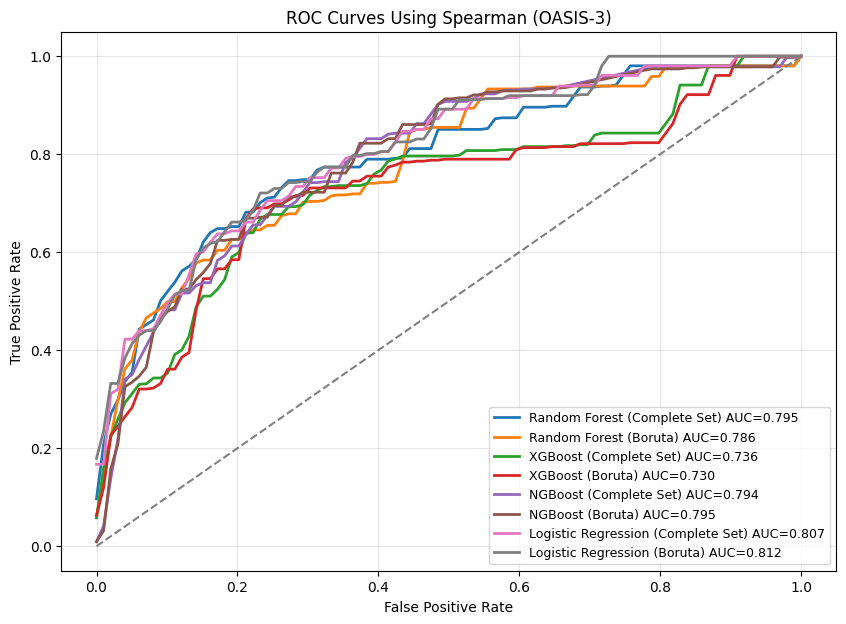

In [38]:
# ROC AUC plotting for ALL models
models_dict = {
    "Random Forest": {"Complete Set": trained_rf_n, "Boruta": trained_rf_t},
    "XGBoost": {"Complete Set": trained_xgb_n, "Boruta": trained_xgb_t},
    "NGBoost": {"Complete Set": trained_ngb_n, "Boruta": trained_ngb_t},
    "Logistic Regression": {"Complete Set": trained_lg_n, "Boruta": trained_lg_t}
}

X_tests_dict = {
    "Complete Set": X_test_missForest_t,
    "Boruta": X_test_t
}

plot_roc_multi(models_dict, X_tests_dict, y_test, show_per_class=False)